In [100]:
# -*- coding: utf-8 -*-

"""
Testing pysptk
"""

'\nTesting pysptk\n'

In [2]:
from __future__ import division, print_function

import os
from shutil import rmtree
import argparse
import glob
import pickle
import time

import numpy as np
from numpy.linalg import norm 
from sklearn.decomposition import PCA
from sklearn.mixture import GMM # sklearn 0.20.0から使えない
from sklearn.preprocessing import StandardScaler
import scipy.signal
import scipy.sparse

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style="dark")
plt.rcParams['figure.figsize'] = (16, 5)
from IPython.display import Audio 

import soundfile as sf
import wave 
import pyworld as pw
import librosa.display
import pysptk

from dtw import dtw
import warnings
warnings.filterwarnings('ignore')

In [4]:
def analyse(x, fs, fftl=1024, shiftms=5.0):
    """
    従来法. stonemaskあり.
    """
    _f0, time_axis = pw.harvest(x, fs, frame_period=shiftms)
    f0 = pw.stonemask(x, _f0, time_axis, fs)
    spc = pw.cheaptrick(x, f0, time_axis, fs, fft_size=fftl)
    ap = pw.d4c(x, f0, time_axis, fs, fft_size=fftl)
    
    return f0, spc, ap

def analyse_1(x, fs, fftl=1024, shiftms=5.0):
    """
    従来法. stonemaskなし.
    """
    f0, time_axis = pw.harvest(x, fs, frame_period=shiftms)
    spc = pw.cheaptrick(x, f0, time_axis, fs, fft_size=fftl)
    ap = pw.d4c(x, f0, time_axis, fs, fft_size=fftl)
    
    return f0, spc, ap

def analyse_spr(x, fs, fftl=1024, shiftms=5.0, minf0=40.0, maxf0=500.0):
    """
    sprocketの方法. 上限と下限を追加. stonemaskなし.
    """
    f0, time_axis = pw.harvest(x, fs, f0_floor=minf0, f0_ceil=maxf0, frame_period=shiftms)
    spc = pw.cheaptrick(x, f0, time_axis, fs, fft_size=fftl)
    ap = pw.d4c(x, f0, time_axis, fs, fft_size=fftl)
    
    return f0, spc, ap

def analyse_spr_2(x, fs, fftl=1024, shiftms=5.0, minf0=40.0, maxf0=500.0):
    """
    sprocketの方法. 上限と下限を追加. stonemaskあり.
    """
    
    _f0, time_axis = pw.harvest(x, fs, f0_floor=minf0, f0_ceil=maxf0, frame_period=shiftms)
    f0 = pw.stonemask(x, _f0, time_axis, fs)
    spc = pw.cheaptrick(x, f0, time_axis, fs, fft_size=fftl)
    ap = pw.d4c(x, f0, time_axis, fs, fft_size=fftl)
    
    return f0, spc, ap


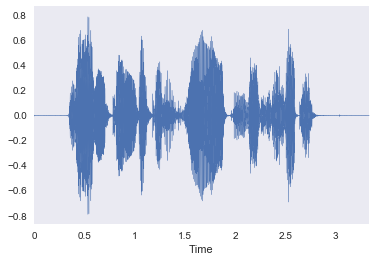

In [7]:
frame_length = 1024
hop_length = 80
dim = 24
alpha = 0.42

path = 'utterance/'
file_name = 'A02'
syn = '.wav'
name = path + file_name + syn

x, fs = sf.read(name)
assert fs == 16000

librosa.display.waveplot(x, sr=fs)
#plt.savefig(path +'origin_' + file_name + '.png', format='png', dpi=300)
#plt.close()
Audio(x, rate=fs)

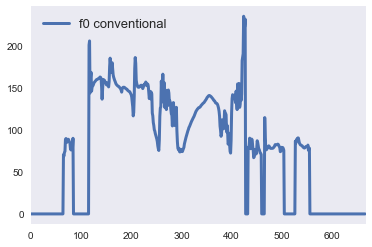

In [8]:
f0_a, sp_a, ap_a = analyse(x, fs)
plt.plot(f0_a, linewidth=3, label="f0 conventional")
plt.xlim(0, len(f0_a))
plt.legend(prop={'size': 13})

In [137]:
f0_a, sp_a, ap_a = analyse(x, fs)
plt.plot(f0_a, linewidth=3, label="f0 conventional")
plt.xlim(0, len(f0_a))
plt.legend(prop={'size': 13})
#plt.savefig(path +'f0_conv_' + file_name + '.png', format='png', dpi=300)
#plt.close()

mc = pysptk.sp2mc(sp_a, dim, alpha)
mc_t = mc.T
plt.plot(mc_t[0], linewidth=2, label="mcep conventional")
plt.xlim(0, len(mc_t[0]))
plt.legend(prop={'size': 13})
#plt.savefig(path +'mcep_conv_' + file_name + '.png', format='png', dpi=300)
#plt.close()

spc = pysptk.mc2sp(mc, alpha, frame_length)
sp_t = sp_a.T
spc_t = spc.T
plt.plot(sp_t[0], linewidth=2, label="spec trajectry by WORLD")
plt.plot(spc_t[0], linewidth=2, label="spec trajectry from mcep")
plt.xlim(0, len(sp_t[0]))
plt.legend(prop={'size': 13})
#plt.savefig(path +'mc2sp_conv_' + file_name + '.png', format='png', dpi=300)
#plt.close()

wav = pw.synthesize(f0_a, spc, ap_a, fs)
librosa.display.waveplot(wav, sr=fs)
plt.savefig(path +'mc2sp_wav_conv_' + file_name + '.png', format='png', dpi=300)
#plt.close()
Audio(wav, rate=fs)
sf.write(path + 'mc2sp_conv_' +file_name + '.wav', wav, fs)

wav = pw.synthesize(f0_a, sp_a, ap_a, fs)
librosa.display.waveplot(wav, sr=fs)
plt.savefig(path +'anasys_conv_' + file_name + '.png', format='png', dpi=300)
plt.close()
Audio(wav, rate=fs)
sf.write(path + 'anasys_conv_' +file_name + '.wav', wav, fs)

In [138]:
f0_b, sp_b, ap_b = analyse_1(x, fs)
plt.plot(f0_b, linewidth=3, label="conventional without stonemask")
plt.xlim(0, len(f0_b))
plt.legend(prop={'size': 13})
plt.savefig(path +'f0_conv_wi_' + file_name + '.png', format='png', dpi=300)
plt.close()

mc = pysptk.sp2mc(sp_b, dim, alpha)
mc_t = mc.T
plt.plot(mc_t[0], linewidth=2, label="mcep conventional without stonemask")
plt.xlim(0, len(mc_t[0]))
plt.legend(prop={'size': 13})
plt.savefig(path +'mcep_conv_wi_' + file_name + '.png', format='png', dpi=300)
plt.close()

spc = pysptk.mc2sp(mc, alpha, frame_length)
sp_t = sp_b.T
spc_t = spc.T
plt.plot(sp_t[0], linewidth=2, label="spec trajectry by WORLD")
plt.plot(spc_t[0], linewidth=2, label="spec trajectry from mcep")
plt.xlim(0, len(sp_t[0]))
plt.legend(prop={'size': 13})
plt.savefig(path +'mc2sp_conv_wi_' + file_name + '.png', format='png', dpi=300)
plt.close()

wav = pw.synthesize(f0_b, spc, ap_b, fs)
librosa.display.waveplot(wav, sr=fs)
plt.savefig(path +'mc2sp_wav_conv_wi_' + file_name + '.png', format='png', dpi=300)
plt.close()
Audio(wav, rate=fs)
sf.write(path + 'mc2sp_conv_wi_' +file_name + '.wav', wav, fs)

wav = pw.synthesize(f0_b, sp_b, ap_b, fs)
librosa.display.waveplot(wav, sr=fs)
plt.savefig(path +'anasys_conv_wi_' + file_name + '.png', format='png', dpi=300)
plt.close()
Audio(wav, rate=fs)
sf.write(path + 'anasys_conv_wi_' +file_name + '.wav', wav, fs)

In [139]:
f0_c, sp_c, ap_c = analyse_spr(x, fs)
plt.plot(f0_c, linewidth=3, label="f0 sprocket")
plt.xlim(0, len(f0_c))
plt.legend(prop={'size': 13})
plt.savefig(path +'f0_spr_' + file_name + '.png', format='png', dpi=300)
plt.close()

mc = pysptk.sp2mc(sp_c, dim, alpha)
mc_t = mc.T
plt.plot(mc_t[0], linewidth=2, label="mcep sprocket")
plt.xlim(0, len(mc_t[0]))
plt.legend(prop={'size': 13})
plt.savefig(path +'mcep_spr_' + file_name + '.png', format='png', dpi=300)
plt.close()

spc = pysptk.mc2sp(mc, alpha, frame_length)
sp_t = sp_c.T
spc_t = spc.T
plt.plot(sp_t[0], linewidth=2, label="spec trajectry by WORLD")
plt.plot(spc_t[0], linewidth=2, label="spec trajectry from mcep")
plt.xlim(0, len(sp_t[0]))
plt.legend(prop={'size': 13})
plt.savefig(path +'mc2sp_spr_' + file_name + '.png', format='png', dpi=300)
plt.close()

wav = pw.synthesize(f0_c, spc, ap_c, fs)
librosa.display.waveplot(wav, sr=fs)
plt.savefig(path +'mc2sp_wav_spr_' + file_name + '.png', format='png', dpi=300)
plt.close()
Audio(wav, rate=fs)
sf.write(path + 'mc2sp_spr_' +file_name + '.wav', wav, fs)

wav = pw.synthesize(f0_c, sp_c, ap_c, fs)
librosa.display.waveplot(wav, sr=fs)
plt.savefig(path +'anasys_spr_' + file_name + '.png', format='png', dpi=300)
plt.close()
Audio(wav, rate=fs)
sf.write(path + 'anasys_spr_' +file_name + '.wav', wav, fs)

In [140]:
f0_d, sp_d, ap_d = analyse_spr_2(x, fs)
plt.plot(f0_d, linewidth=3, label="f0 sprocket with stonemask")
plt.xlim(0, len(f0_d))
plt.legend(prop={'size': 13})
plt.savefig(path +'f0_spr_w_' + file_name + '.png', format='png', dpi=300)
plt.close()

mc = pysptk.sp2mc(sp_d, dim, alpha)
mc_t = mc.T
plt.plot(mc_t[0], linewidth=2, label="mcep sprocket with stone mask")
plt.xlim(0, len(mc_t[0]))
plt.legend(prop={'size': 13})
plt.savefig(path +'mcep_spr_w_' + file_name + '.png', format='png', dpi=300)
plt.close()

spc = pysptk.mc2sp(mc, alpha, frame_length)
sp_t = sp_d.T
spc_t = spc.T
plt.plot(sp_t[0], linewidth=2, label="spec trajectry by WORLD")
plt.plot(spc_t[0], linewidth=2, label="spec trajectry from mcep")
plt.xlim(0, len(sp_t[0]))
plt.legend(prop={'size': 13})
plt.savefig(path +'mc2sp_spr_w_' + file_name + '.png', format='png', dpi=300)
plt.close()

wav = pw.synthesize(f0_d, spc, ap_d, fs)
librosa.display.waveplot(wav, sr=fs)
plt.savefig(path +'mc2sp_wav_spr_w_' + file_name + '.png', format='png', dpi=300)
plt.close()
Audio(wav, rate=fs)
sf.write(path + 'mc2sp_spr_w_' +file_name + '.wav', wav, fs)

wav = pw.synthesize(f0_d, sp_d, ap_d, fs)
librosa.display.waveplot(wav, sr=fs)
plt.savefig(path +'anasys_spr_w_' + file_name + '.png', format='png', dpi=300)
plt.close()
Audio(wav, rate=fs)
sf.write(path + 'anasys_spr_w_' + file_name + '.wav', wav, fs)